<a href="https://colab.research.google.com/github/AtakaNKuscu/Physics-Informed-Neural-Networks/blob/main/underdampedsystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[LBFGS] step= 70 | L=6.262e-04


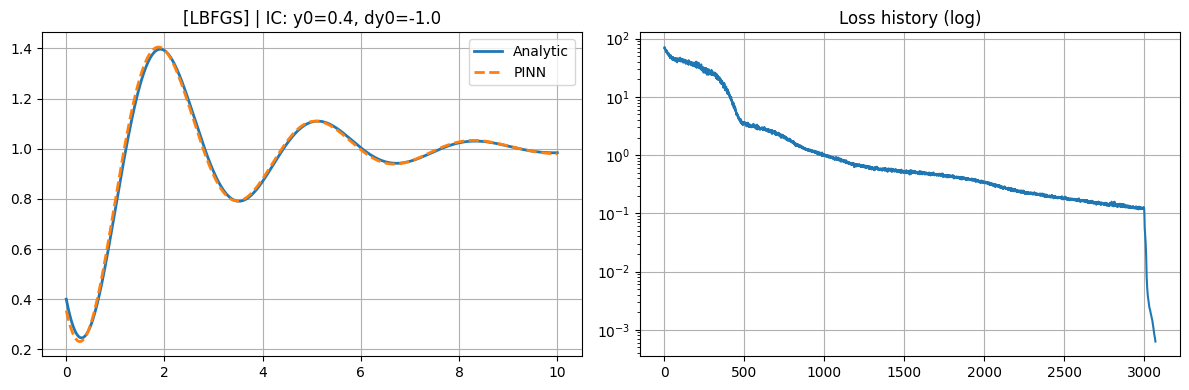

LBFGS finished.


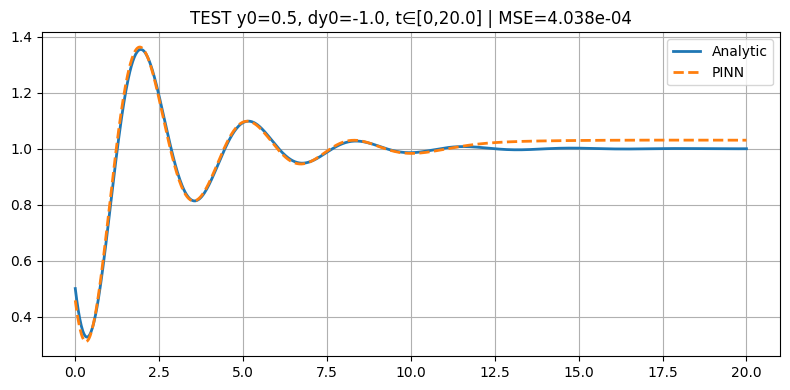

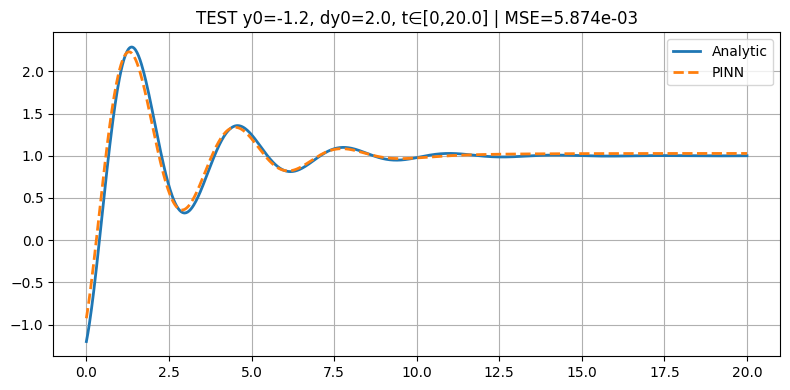

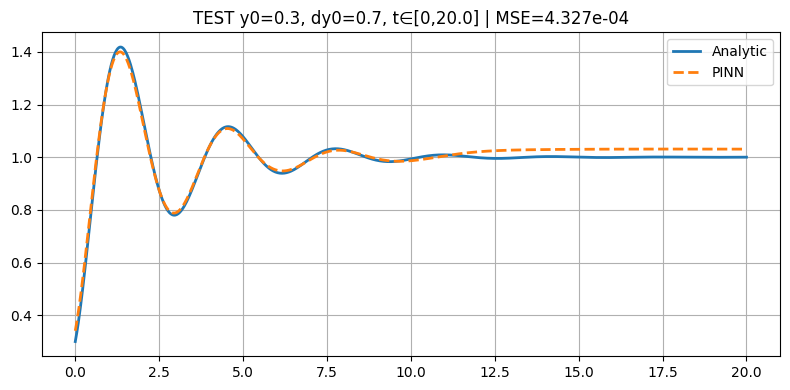

In [ ]:
# ============================================================
# FINAL UNIVERSAL PINN (NO EQUILIBRIUM IC / NO EQ DATA)
# WITH: L_data + tau-based SS + mild scaling + warmup
# AND: Adam visuals + LBFGS iterative visuals
# ============================================================

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

try:
    from IPython.display import clear_output
    HAS_IPY = True
except:
    HAS_IPY = False

# ----------------------------
# Device & dtype
# ----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_dtype(torch.float32)
print("Device:", device)

def tf32(x):
    return torch.tensor(x, device=device, dtype=torch.float32)

# ----------------------------
# System parameters
# ----------------------------
zeta = 0.2
wn   = 2.0
a1   = 2*zeta*wn
a0   = wn**2
rhs  = wn**2

# ----------------------------
# Tau-based SS window (your rule)
# ----------------------------
tau = 1.0/(zeta*wn)
k_tau = 5.0
T_ss_min = float(k_tau * tau)
T_ss_max = float(T_ss_min + 2.0 * tau)
print(f"tau={tau:.3f}s, SS window=[{T_ss_min:.2f}, {T_ss_max:.2f}]")

# ----------------------------
# Mild input scaling
# ----------------------------
t_scale   = 5.0
y0_scale  = 2.0
dy0_scale = 3.0

# ----------------------------
# True solution (for synthetic data + evaluation only)
# ----------------------------
def true_solution(t, y0, dy0):
    t = np.asarray(t, dtype=np.float32).reshape(-1,1)
    wd = wn*np.sqrt(1 - zeta**2)
    C1 = y0 - 1.0
    C2 = (dy0 + zeta*wn*C1)/wd
    return 1.0 + np.exp(-zeta*wn*t)*(C1*np.cos(wd*t) + C2*np.sin(wd*t))

# ----------------------------
# Network
# ----------------------------
class UniversalPINN(nn.Module):
    def __init__(self, width=64, depth=4):
        super().__init__()
        layers = [nn.Linear(3, width), nn.Tanh()]
        for _ in range(depth-1):
            layers += [nn.Linear(width, width), nn.Tanh()]
        layers += [nn.Linear(width, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

model = UniversalPINN().to(device)

def model_forward(t, y0, dy0):
    # mild scaling (not full normalization)
    t_s   = t  / t_scale
    y0_s  = y0 / y0_scale
    dy0_s = dy0 / dy0_scale
    x = torch.cat([t_s, y0_s, dy0_s], dim=1)
    return model(x)

# ----------------------------
# Sampling
# ----------------------------
def sample_uniform(N, low, high):
    low = float(low); high = float(high)
    return (low + (high-low)*torch.rand(N,1, device=device, dtype=torch.float32))

# ----------------------------
# Physics residual
# ----------------------------
def physics_residual(t, y0, dy0):
    t = t.clone().detach().requires_grad_(True)
    y = model_forward(t, y0, dy0)
    dy = torch.autograd.grad(y, t, torch.ones_like(y), create_graph=True)[0]
    d2y= torch.autograd.grad(dy, t, torch.ones_like(dy), create_graph=True)[0]
    return d2y + a1*dy + a0*y - rhs

# ----------------------------
# SS loss (tau-based, no derivatives)
# ----------------------------
def ss_loss_tau(t_ss, y0_ss, dy0_ss):
    y = model_forward(t_ss, y0_ss, dy0_ss)
    return torch.mean((y - 1.0)**2)

# ----------------------------
# Sparse measurement data (NO equilibrium traj)
# ----------------------------
def build_data(M_traj=6, dt=0.5, tmax=10.0, seed=1,
               y0_range=(-2,2), dy0_range=(-3,3)):
    rng = np.random.default_rng(seed)
    t_grid = np.arange(0.0, tmax+1e-9, dt, dtype=np.float32)

    y0_list  = rng.uniform(y0_range[0],  y0_range[1],  size=(M_traj,))
    dy0_list = rng.uniform(dy0_range[0], dy0_range[1], size=(M_traj,))

    T, Y0, DY0, Y = [], [], [], []
    for y0, dy0 in zip(y0_list, dy0_list):
        y = true_solution(t_grid, float(y0), float(dy0)).reshape(-1).astype(np.float32)
        T.append(t_grid)
        Y0.append(np.full_like(t_grid, y0,  dtype=np.float32))
        DY0.append(np.full_like(t_grid, dy0, dtype=np.float32))
        Y.append(y)

    T   = np.concatenate(T).astype(np.float32)
    Y0  = np.concatenate(Y0).astype(np.float32)
    DY0 = np.concatenate(DY0).astype(np.float32)
    Y   = np.concatenate(Y).astype(np.float32)

    t_d   = torch.tensor(T,   device=device, dtype=torch.float32).view(-1,1)
    y0_d  = torch.tensor(Y0,  device=device, dtype=torch.float32).view(-1,1)
    dy0_d = torch.tensor(DY0, device=device, dtype=torch.float32).view(-1,1)
    y_d   = torch.tensor(Y,   device=device, dtype=torch.float32).view(-1,1)

    info = {"y0_list": y0_list.tolist(), "dy0_list": dy0_list.tolist(), "t_grid": t_grid}
    return (t_d, y0_d, dy0_d, y_d), info

# ----------------------------
# Visualization helper
# ----------------------------
def plot_status(loss_hist, tmax, view_ic, title):
    y0v, dy0v = float(view_ic[0]), float(view_ic[1])
    t = np.linspace(0, tmax, 700, dtype=np.float32)
    tt = torch.tensor(t, device=device, dtype=torch.float32).view(-1,1)

    with torch.no_grad():
        yp = model_forward(
            tt,
            torch.full_like(tt, y0v),
            torch.full_like(tt, dy0v)
        ).cpu().numpy().reshape(-1)

    yt = true_solution(t, y0v, dy0v).reshape(-1)

    fig, axs = plt.subplots(1,2, figsize=(12,4))
    axs[0].plot(t, yt, label="Analytic", lw=2)
    axs[0].plot(t, yp, "--", label="PINN", lw=2)
    axs[0].grid(); axs[0].legend()
    axs[0].set_title(title + f" | IC: y0={y0v}, dy0={dy0v}")

    axs[1].plot(loss_hist)
    axs[1].set_yscale("log")
    axs[1].grid()
    axs[1].set_title("Loss history (log)")
    plt.tight_layout()
    plt.show()

# ============================================================
# Training parameters
# ============================================================
t_train_max = 10.0
y0_range  = (-2.0, 2.0)
dy0_range = (-3.0, 3.0)

Nf  = 1024
Nic = 256
Nss = 64

lambda_ic   = 10.0
lambda_data = 20.0
lambda_ss   = 0.05

epochs_adam = 3000
warmup_phys = 500
lr_adam     = 2e-4
clip_norm   = 1.0

view_ic = (0.4, -1.0)   # monitor a "random" IC
vis_every_adam  = 200
vis_every_lbfgs = 10

# ----------------------------
# Data
# ----------------------------
(t_d, y0_d, dy0_d, y_d), data_info = build_data(
    M_traj=6, dt=0.5, tmax=t_train_max, seed=2,
    y0_range=y0_range, dy0_range=dy0_range
)
print("Data traj ICs:")
for k,(yy0,ddy0) in enumerate(zip(data_info["y0_list"], data_info["dy0_list"])):
    print(f"  traj {k}: y0={yy0:.3f}, dy0={ddy0:.3f}")

# ----------------------------
# Warmup for physics
# ----------------------------
def lambda_phys(epoch):
    return min(1.0, epoch / warmup_phys)

# ============================================================
# ADAM TRAINING
# ============================================================
opt = torch.optim.Adam(model.parameters(), lr=lr_adam)
loss_hist = []

for ep in range(epochs_adam):
    opt.zero_grad()

    # physics batch
    t_f   = sample_uniform(Nf, 0.0, t_train_max)
    y0_f  = sample_uniform(Nf, y0_range[0],  y0_range[1])
    dy0_f = sample_uniform(Nf, dy0_range[0], dy0_range[1])
    L_phys = torch.mean(physics_residual(t_f, y0_f, dy0_f)**2)

    # IC batch (NO equilibrium)
    t0 = torch.zeros(Nic,1, device=device, dtype=torch.float32).requires_grad_(True)
    y0 = sample_uniform(Nic, y0_range[0],  y0_range[1])
    dy0= sample_uniform(Nic, dy0_range[0], dy0_range[1])

    y0p = model_forward(t0, y0, dy0)
    dy0p = torch.autograd.grad(y0p, t0, torch.ones_like(y0p), create_graph=True)[0]
    L_ic = torch.mean((y0p-y0)**2 + (dy0p-dy0)**2)

    # data
    L_data = torch.mean((model_forward(t_d, y0_d, dy0_d) - y_d)**2)

    # ss (time-based)
    t_ss   = sample_uniform(Nss, T_ss_min, T_ss_max)
    y0_ss  = sample_uniform(Nss, y0_range[0],  y0_range[1])
    dy0_ss = sample_uniform(Nss, dy0_range[0], dy0_range[1])
    L_ss = ss_loss_tau(t_ss, y0_ss, dy0_ss)

    lam_p = lambda_phys(ep)
    loss = lam_p*L_phys + lambda_ic*L_ic + lambda_data*L_data + lambda_ss*L_ss

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
    opt.step()

    loss_hist.append(float(loss.detach().cpu()))

    if ep % vis_every_adam == 0:
        if HAS_IPY: clear_output(wait=True)
        print(f"[Adam] ep={ep:4d} | L={loss.item():.3e} | lam_phys={lam_p:.2f} | "
              f"phys={L_phys.item():.2e} | ic={L_ic.item():.2e} | data={L_data.item():.2e} | ss={L_ss.item():.2e}")
        plot_status(loss_hist, t_train_max, view_ic, "[Adam]")

print("Adam finished.")

# ============================================================
# LBFGS (ITERATIVE + VISUALS)
# Key fix: max_iter=1 + external loop => you see iterations
# Deterministic batches (physics/data/ss fixed)
# ============================================================
lbfgs_steps = 80

opt_lbfgs = torch.optim.LBFGS(
    model.parameters(),
    lr=1.0,
    max_iter=20,              # IMPORTANT: one internal iter per outer step
    history_size=50,
    line_search_fn="strong_wolfe"
)

# fixed physics batch
t_f_fix   = sample_uniform(Nf, 0.0, t_train_max)
y0_f_fix  = sample_uniform(Nf, y0_range[0],  y0_range[1])
dy0_f_fix = sample_uniform(Nf, dy0_range[0], dy0_range[1])

# fixed ss batch
t_ss_fix   = sample_uniform(Nss, T_ss_min, T_ss_max)
y0_ss_fix  = sample_uniform(Nss, y0_range[0],  y0_range[1])
dy0_ss_fix = sample_uniform(Nss, dy0_range[0], dy0_range[1])

def closure():
    opt_lbfgs.zero_grad()

    L_phys = torch.mean(physics_residual(t_f_fix, y0_f_fix, dy0_f_fix)**2)
    L_data = torch.mean((model_forward(t_d, y0_d, dy0_d) - y_d)**2)
    L_ss   = ss_loss_tau(t_ss_fix, y0_ss_fix, dy0_ss_fix)

    L = L_phys + lambda_data*L_data + lambda_ss*L_ss
    L.backward()
    return L

for step in range(lbfgs_steps):
    L = opt_lbfgs.step(closure)
    loss_hist.append(float(L.detach().cpu()))

    if step % vis_every_lbfgs == 0:
        if HAS_IPY: clear_output(wait=True)
        print(f"[LBFGS] step={step:3d} | L={L.item():.3e}")
        plot_status(loss_hist, t_train_max, view_ic, "[LBFGS]")

print("LBFGS finished.")

# ============================================================
# TESTS (no equilibrium test)
# ============================================================
def test_ic(y0, dy0, tmax=20.0):
    t = np.linspace(0, tmax, 900, dtype=np.float32)
    tt = torch.tensor(t, device=device, dtype=torch.float32).view(-1,1)
    with torch.no_grad():
        yp = model_forward(
            tt,
            torch.full_like(tt, float(y0)),
            torch.full_like(tt, float(dy0))
        ).cpu().numpy().reshape(-1)
    yt = true_solution(t, float(y0), float(dy0)).reshape(-1)
    mse = float(np.mean((yp - yt)**2))

    plt.figure(figsize=(8,4))
    plt.plot(t, yt, label="Analytic", lw=2)
    plt.plot(t, yp, "--", label="PINN", lw=2)
    plt.grid(); plt.legend()
    plt.title(f"TEST y0={y0}, dy0={dy0}, t∈[0,{tmax}] | MSE={mse:.3e}")
    plt.tight_layout()
    plt.show()

test_ic(0.5, -1.0, tmax=20.0)
test_ic(-1.2, 2.0, tmax=20.0)
test_ic(0.3, 0.7, tmax=20.0)
